In [1]:
%matplotlib notebook
import numpy as np
import os
import sys
np.random.seed(1)
import torch
torch.manual_seed(1)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import SubsetRandomSampler
import matplotlib
from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
sys.path.append(r'C:\lior\studies\master\projects\calibration\regression calibration\regression_calibration')
os.chdir(r'C:\lior\studies\master\projects\calibration\regression calibration\regression_calibration')
from src.data.data_generator_endovis import EndoVisDataset
from cqr_model import BreastPathQModel
from uce import uceloss, enceloss
from src.features.calibration_plots import plot_uncert, plot_frequency, plot_uncert_multi
from utils import nll_criterion_gaussian, avg_len
from scaling import set_scaler, scale_bins

matplotlib.rcParams['font.size'] = 8

In [2]:
base_model = 'efficientnetb4'

In [3]:
assert base_model in ['resnet101', 'densenet201', 'efficientnetb4']
device = torch.device("cuda:0")

In [4]:
batch_size = 16

data_dir_val = 'C:/lior/studies/master/projects/calibration/regression calibration/Tracking_Robotic_Testing/Tracking'
data_dir_test = 'C:/lior/studies/master/projects/calibration/regression calibration/Tracking_Robotic_Testing/Tracking'
data_set_valid = EndoVisDataset(data_dir=data_dir_val, mode='val', augment=False, scale=0.5)
data_set_test = EndoVisDataset(data_dir=data_dir_test, mode='test', augment=False, scale=0.5)

assert len(data_set_valid) > 0
assert len(data_set_test) > 0
print(len(data_set_valid))
print(len(data_set_test))

calib_loader = torch.utils.data.DataLoader(data_set_valid, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(data_set_test, batch_size=batch_size, shuffle=False)

mode 2
mode 1
679
357


In [6]:
from glob import glob
model = BreastPathQModel(base_model, out_channels=2).to(device)

checkpoint_path = glob(f"C:\lior\studies\master\projects\calibration/regression calibration/regression_calibration\models\snapshots\cqr\{base_model}_0.95_endovis_cqr_best_new_val.pth.tar")[0]

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['state_dict'])
print("Loading previous weights at epoch " + str(checkpoint['epoch']) + " from\n" + checkpoint_path)

Loading previous weights at epoch 159 from
C:\lior\studies\master\projects\calibration/regression calibration/regression_calibration\models\snapshots\cqr\efficientnetb4_0.95_endovis_cqr_best_new_val.pth.tar


In [7]:
model.eval()
t_p_calib = []
targets_calib = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(calib_loader)):
        data, target = data.to(device), target.to(device)

        t_p = model(data, dropout=True, mc_dropout=True, test=True)

        t_p_calib.append(t_p.detach())
        targets_calib.append(target.detach())

100%|██████████| 43/43 [02:01<00:00,  2.82s/it]


In [8]:
t_p_calib = torch.cat(t_p_calib, dim=1).clamp(0, 1).permute(1,0,2)
mu_calib = t_p_calib.mean(dim=1)
target_calib = torch.cat(targets_calib, dim=0)

In [9]:
t_p_test_list = []
mu_test_list = []
target_test_list = []

for i in range(5):
    t_p_test = []
    targets_test = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
            data, target = data.to(device), target.to(device)

            t_p = model(data, dropout=True, mc_dropout=True, test=True)

            t_p_test.append(t_p.detach())
            targets_test.append(target.detach())

        t_p_test = torch.cat(t_p_test, dim=1).clamp(0, 1).permute(1,0,2)
        mu_test = t_p_test.mean(dim=1)
        target_test = torch.cat(targets_test, dim=0)

        t_p_test_list.append(t_p_test)
        mu_test_list.append(mu_test)
        target_test_list.append(target_test)

100%|██████████| 23/23 [01:03<00:00,  2.74s/it]


In [10]:
# CQR
import math

def calc_optimal_q(target_calib, mu_calib, alpha=0.1):
    y_lower = mu_calib[:,0]
    y_upper = mu_calib[:,-1]
    error_low = y_lower - target_calib
    error_high = target_calib - y_upper
    err = torch.maximum(error_high, error_low)
    err, _ = torch.sort(err, 0)
    index = int(math.ceil((1 - alpha) * (err.shape[0] + 1))) - 1
    index = min(max(index, 0), err.shape[0] - 1)
    q = err[index]
    
    return q

q = calc_optimal_q(target_calib.mean(dim=1), mu_calib)
print(q)

tensor(-0.0791, device='cuda:0')


In [11]:
import pickle

save_path = 'C:/lior/studies/master/projects/calibration/regression calibration/regression_calibration/reports/var_and_mse_calib/'
with open(save_path + f'{base_model}_endovis_095_cqr_val.pickle', 'wb') as handle:
    pickle.dump({'mu': [mu_calib, mu_test_list],
                 'target': [target_calib, target_test_list],
                 'q': q}
                , handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
import pickle

save_path = 'C:/lior/studies/master/projects/calibration/regression calibration/regression_calibration/reports/var_and_mse_calib/'
with open(save_path + f'{base_model}_endovis_095_cqr_val.pickle', 'rb') as handle:
    calib_dict = pickle.load(handle)
    mu_calib = calib_dict['mu'][0]
    mu_test_list = calib_dict['mu'][1]
    target_calib = calib_dict['target'][0]
    target_test_list = calib_dict['target'][1]
    q = calib_dict['q']

In [13]:
import math

def calc_optimal_q(target_calib, mu_calib, alpha=0.1):
        y_lower = mu_calib[:,0]
        y_upper = mu_calib[:,-1]
        error_low = y_lower - target_calib
        error_high = target_calib - y_upper
        err = torch.maximum(error_high, error_low)
        err, _ = torch.sort(err, 0)
        # index = int(math.ceil((1 - alpha) * (err.shape[0] + 1))) - 1
        index = math.ceil(len(err) * (1 - alpha))
        index = min(max(index, 0), err.shape[0] - 1)
        q = err[index]
        
        return q

# def calc_optimal_q(target_calib, mu_calib, alpha=0.05):

#     lower_e = mu_calib[:, 0] - target_calib
#     higher_e = target_calib - mu_calib[:, 1]
#     s_t = torch.max(torch.stack((lower_e, higher_e), -1), -1).values
#     s_t_sorted, _ = torch.sort(s_t, dim=0)
#     # q_index = math.ceil((len(s_t_sorted) + 1) * (1 - alpha))
#     q_index = math.ceil(len(s_t_sorted) * (1 - alpha))
#     q = s_t_sorted[q_index].item()
#     # q = torch.quantile(s_t, (1 - alpha))
    
#     return q

In [16]:
#CQR prediction

def set_scaler_conformal(target_calib, mu_calib, init_temp=2.5, log=True):
    """
    Tune single scaler for the model (using the validation set) with cross-validation on NLL
    """
        
    printed_type = 'CQR'
            
    # Calculate optimal q
    q = calc_optimal_q(target_calib.mean(dim=1), mu_calib, alpha=0.05)
    # q = calc_optimal_q(target_calib[:, 0], mu_calib, alpha=0.1)
    
    after_single_scaling_avg_len = torch.mean(abs((mu_calib[:, 1] + q) - (mu_calib[:, 0] - q)))
    # after_single_scaling_avg_len = ((mu_calib[1] + q) - (mu_calib[0] - q)).mean()
    print('Optimal scaler {} (val): {:.3f}'.format(printed_type, q))
    print('After single scaling- Avg Length {} (val): {}'.format(printed_type, after_single_scaling_avg_len))
    
    after_single_scaling_avg_cov = avg_cov(mu_calib, q, target_calib.mean(dim=1))
    print('After single scaling- Avg Cov {} (val): {}'.format(printed_type, after_single_scaling_avg_cov))
    
    return q

def avg_cov(mu, q, target, before=False):
    if before:
        in_the_range = torch.sum((target >= mu[:, 0]) & (target <= mu[:, 1]))
    else:
        in_the_range = torch.sum((target >= (mu[:, 0] - q)) & (target <= (mu[:, 1] + q)))
    coverage = in_the_range / len(target) * 100
    
    return coverage
    # total_cov = 0.0
    # for mu_single, target_single in zip(mu, target):
    #     if before:
    #         if mu_single[0] <= target_single <= mu_single[1]:
    #             total_cov += 1.0
    #     else:
    #         if mu_single[0] - q <= target_single <= mu_single[1] + q:
    #             total_cov += 1.0
            
    # return total_cov / len(mu)

def scale_bins_single_conformal(mu_test, q):
    
    # Calculate Avg Length before temperature scaling
    before_scaling_avg_len = torch.mean(abs(mu_test[:, 1] - mu_test[:, 0]))
    # before_scaling_avg_len = (mu_test[1] - mu_test[0]).mean()
    print('Before scaling - Avg Length: %.3f' % (before_scaling_avg_len))
        
    # Calculate Avg Length after single scaling
    after_single_scaling_avg_len = torch.mean(abs((mu_test[:, 1] + q) - (mu_test[:, 0] - q)))
    # after_single_scaling_avg_len = ((mu_test[1] + q) - (mu_test[0] - q)).mean()
    print('Optimal scaler: %.3f' % q)
    print(f'After single scaling- Avg Length: {after_single_scaling_avg_len}')
    
    return after_single_scaling_avg_len, before_scaling_avg_len

In [18]:
# CQR
avg_len_before_list = []
avg_len_single_list = []

avg_cov_before_list = []
avg_cov_after_single_list = []

for i in range(len(mu_test_list)):
    q = set_scaler_conformal(target_calib, mu_calib)
                
    avg_len_single, avg_len_before = scale_bins_single_conformal(mu_test_list[i], q)
    
    avg_cov_before = avg_cov(mu_test_list[i], q, target_test_list[i].mean(dim=1), before=True)
    avg_cov_after_single = avg_cov(mu_test_list[i], q, target_test_list[i].mean(dim=1))
    # avg_cov_before = avg_cov(mu_test_list[i], q, target_test_list[i][:, 0], before=True)
    # avg_cov_after_single = avg_cov(mu_test_list[i], q, target_test_list[i][:, 0])
    
    avg_len_before_list.append(avg_len_before.cpu())
    avg_len_single_list.append(avg_len_single.cpu())
    
    avg_cov_before_list.append(avg_cov_before)
    avg_cov_after_single_list.append(avg_cov_after_single)
    
print(f'Test before, Avg Length:', torch.stack(avg_len_before_list).mean().item())
print(f'Test after single, Avg Length:', torch.stack(avg_len_single_list).mean().item())

print(f'Test before with Avg Cov:', torch.tensor(avg_cov_before_list).mean().item())
print(f'Test after single with Avg Cov:', torch.tensor(avg_cov_after_single_list).mean().item())

Optimal scaler CQR (val): -0.068
After single scaling- Avg Length CQR (val): 0.12648895382881165
After single scaling- Avg Cov CQR (val): 95.28718566894531
Before scaling - Avg Length: 0.226
Optimal scaler: -0.068
After single scaling- Avg Length: 0.08940409123897552
Optimal scaler CQR (val): -0.068
After single scaling- Avg Length CQR (val): 0.12648895382881165
After single scaling- Avg Cov CQR (val): 95.28718566894531
Before scaling - Avg Length: 0.225
Optimal scaler: -0.068
After single scaling- Avg Length: 0.08871550112962723
Optimal scaler CQR (val): -0.068
After single scaling- Avg Length CQR (val): 0.12648895382881165
After single scaling- Avg Cov CQR (val): 95.28718566894531
Before scaling - Avg Length: 0.226
Optimal scaler: -0.068
After single scaling- Avg Length: 0.08974948525428772
Optimal scaler CQR (val): -0.068
After single scaling- Avg Length CQR (val): 0.12648895382881165
After single scaling- Avg Cov CQR (val): 95.28718566894531
Before scaling - Avg Length: 0.226
Optim

In [65]:
if base_model == 'resnet101':
    uce_range = [0, 0.00025]
elif base_model == 'densenet201':
    uce_range = [0, 0.0005]
elif base_model == 'efficientnetb4':
    uce_range = [0, 0.0008]

n_bins = 15
uce_uncal_list = []
err_uncal_list = []
uncert_uncal_list = []
ence_bins_list = []
for i in range(len(err_test)):
    print((uncert_test[i]**2).max().item())
    # uce_uncal, err_uncal, uncert_uncal, _, uce_per_bin = uceloss(err_test[i]**2, uncert_test[i]**2, n_bins=n_bins, range=uce_range)
    uce_uncal, err_uncal, uncert_uncal, _, uce_per_bin = uceloss(err_test[i]**2, uncert_test[i]**2, n_bins=n_bins)
    ence_bins = enceloss(err_test[i]**2, uncert_test[i]**2, n_bins=15, single=True)
    uce_uncal_list.append(uce_uncal.cpu())
    err_uncal_list.append(err_uncal.cpu())
    uncert_uncal_list.append(uncert_uncal.cpu())
    ence_bins_list.append(ence_bins.cpu())

print((torch.stack(uce_uncal_list)*100).mean().item(), (torch.stack(uce_uncal_list)*100).var().sqrt().item())
print((torch.stack(ence_bins_list)).mean().item())
# plot_uncert_multi(err_uncal_list, uncert_uncal_list)

0.0009809262119233608
0.0009839815320447087
0.001031788531690836
0.0009687853162176907
0.000951828493271023
0.04367686063051224 0.0010449661640450358
4.487668037414551


In [66]:
if base_model == 'resnet101':
    uce_range = [0, 0.003]
elif base_model == 'densenet201':
    uce_range = [0, 0.0045]
elif base_model == 'efficientnetb4':
    uce_range = [0, 0.003]

n_bins = 15
uce_s_list = []
err_s_list = []
uncert_s_list = []
ence_bins_list = []
for i in range(len(err_test)):
    print((scaler_laves(uncert_test_laves[i])**2).max().item())
    # uce_s, err_s, uncert_s, _, uce_per_bin = uceloss(err_test[i]**2, scaler_laves(uncert_test_laves[i])**2, n_bins=n_bins, range=uce_range)
    uce_s, err_s, uncert_s, _, uce_per_bin = uceloss(err_test[i]**2, scaler_laves(uncert_test_laves[i])**2, n_bins=n_bins)
    ence_bins = enceloss(err_test[i]**2, scaler_laves(uncert_test_laves[i])**2, n_bins=15, single=True)
    uce_s_list.append(uce_s.cpu())
    err_s_list.append(err_s.cpu())
    uncert_s_list.append(uncert_s.cpu())
    ence_bins_list.append(ence_bins.cpu())
    

print((torch.stack(uce_s_list)*100).mean().item(), (torch.stack(uce_s_list)*100).var().sqrt().item())
print((torch.stack(ence_bins_list)).mean().item())
# plot_uncert_multi(err_s_list, uncert_s_list)

#fig, ax = plot_frequency(scaler_laves(uncert_test_laves[0]).cpu(), in_bin.cpu(), n_bins=n_bins)
#fig.show()

0.002412466099485755
0.002506427699699998
0.002666186774149537
0.0028049787506461143
0.002372179878875613
0.028372401371598244 0.002392886206507683
6.719118595123291


In [68]:
#Ethan
n_bins = 15
uce_s_list = []
err_s_list = []
uncert_s_list = []
ence_bins_list = []
for i in range(len(err_test)):
    print(((S*uncert_test[i])**2).max().item())
    print(S)
    uce_s, err_s, uncert_s, _, uce_per_bin = uceloss(err_test[i]**2, (S*uncert_test[i])**2, n_bins=n_bins)
    ence_bins = enceloss(err_test[i]**2, (S*uncert_test[i])**2, n_bins=15, single=True)
    uce_s_list.append(uce_s.cpu())
    err_s_list.append(err_s.cpu())
    uncert_s_list.append(uncert_s.cpu())
    ence_bins_list.append(ence_bins.cpu())

print((torch.stack(uce_s_list)*100).mean().item(), (torch.stack(uce_s_list)*100).var().sqrt().item())
print((torch.stack(ence_bins_list)).mean().item())

0.0013140456285327673
tensor(1.1574, device='cuda:0')
0.0013181384420022368
tensor(1.1574, device='cuda:0')
0.0013821806060150266
tensor(1.1574, device='cuda:0')
0.0012977817095816135
tensor(1.1574, device='cuda:0')
0.0012750665191560984
tensor(1.1574, device='cuda:0')
0.035435646772384644 0.0022771575022488832
4.704928398132324


In [31]:
if base_model == 'resnet101':
    uce_range = [0, 0.003]
elif base_model == 'densenet201':
    uce_range = [0, 0.0045]
elif base_model == 'efficientnetb4':
    uce_range = [0, 0.003]

n_bins = 15
uce_aux_list = []
err_aux_list = []
uncert_aux_list = []
ence_bins_list = []
for i in range(len(err_test)):
    print((aux(uncert_test[i])**2).max().item())
    uce_aux, _, _, _, uce_per_bin = uceloss(err_test[i]**2, aux(uncert_test[i])**2, n_bins=n_bins)
    ence_bins = enceloss(err_test[i]**2, aux(uncert_test[i])**2, n_bins=15, single=True)
    # _, err_aux, uncert_aux, _, uce_per_bin = uceloss(err_test[i]**2, aux(uncert_test[i])**2, n_bins=n_bins, range=uce_range)
    uce_aux_list.append(uce_aux.cpu())
    ence_bins_list.append(ence_bins.cpu())
    # err_aux_list.append(err_aux.cpu())
    # uncert_aux_list.append(uncert_aux.cpu())

print((torch.stack(uce_aux_list)*100).mean().item(), (torch.stack(uce_aux_list)*100).var().sqrt().item())
print((torch.stack(ence_bins_list)).mean().item())
# plot_uncert_multi(err_aux_list, uncert_aux_list)

0.08002376556396484
0.08063354343175888
0.08604127168655396
0.08434337377548218
0.08650510758161545
0.9994062185287476 0.010339424014091492
7.192543983459473


In [74]:
import seaborn as sns

sns.set()
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{bm}']

In [75]:
def save_log(base_model):
    with open(f"results_levi_endovis_{base_model}.log", "w") as f:
        print("MSE", file=f)
        print([(e**2).mean().item() for e in err_test], file=f)
        print("mean", np.mean([(e**2).mean().item() for e in err_test]), file=f)
        print("std ", np.std([(e**2).mean().item() for e in err_test]), file=f)
        print("", file=f)
        
        print("uncal", file=f)
        print("NLL", file=f)
        nll = [nll_criterion_gaussian(mu_test_list[i], uncert_test[i].pow(2).log(), target_test_list[i]).item() for i in range(len(mu_test_list))]
        print(nll, file=f)
        print("mean", np.mean(nll), file=f)
        print("std ", np.std(nll), file=f)
        print("UCE", file=f)
        print([u.item() for u in uce_uncal_list], file=f)
        print("mean", (torch.stack(uce_uncal_list)*100).mean().item(), file=f)
        print("std ", (torch.stack(uce_uncal_list)*100).var().sqrt().item(), file=f)
        print("", file=f)
        
        print("aux", file=f)
        print("NLL", file=f)
        aux.train()
        nll = [nll_criterion_gaussian(mu_test_list[i], aux(uncert_test[i]), target_test_list[i]).item() for i in range(len(mu_test_list))]
        aux.eval()
        print(nll, file=f)
        print("mean", np.mean(nll), file=f)
        print("std ", np.std(nll), file=f)
        print("UCE", file=f)
        print([u.item() for u in uce_aux_list], file=f)
        print("mean", (torch.stack(uce_aux_list)*100).mean().item(), file=f)
        print("std ", (torch.stack(uce_aux_list)*100).var().sqrt().item(), file=f)
        print("", file=f)
        
        print("s", file=f)
        print("NLL", file=f)
        nll = [nll_criterion_gaussian(mu_test_list[i], scaler(uncert_test[i]).pow(2).log(), target_test_list[i]).item() for i in range(len(mu_test_list))]
        print(nll, file=f)
        print("mean", np.mean(nll), file=f)
        print("std ", np.std(nll), file=f)
        print("UCE", file=f)
        print([u.item() for u in uce_s_list], file=f)
        print("mean", (torch.stack(uce_s_list)*100).mean().item(), file=f)
        print("std ", (torch.stack(uce_s_list)*100).var().sqrt().item(), file=f)
        print("S =", scaler.S.item(), file=f)
        print("", file=f)

In [76]:
if base_model == 'resnet101':
    fig, ax = plt.subplots(1, 3, figsize=(6.8, 2.75))

    alpha = 0.4
    props = dict(boxstyle='round', facecolor='white', alpha=0.75)

    err_uncal = torch.stack(err_uncal_list).mean(dim=0).cpu()
    err_uncal_var = torch.stack(err_uncal_list).var(dim=0).sqrt().cpu()
    uncert_uncal = torch.stack(uncert_uncal_list).mean(dim=0).cpu()
    ax[0].plot([0, 0.2], [0, 0.2], 'k--')
    ax[0].plot(uncert_uncal, err_uncal, marker='.', label='uncal')
    ax[0].fill_between(uncert_uncal, err_uncal-err_uncal_var, err_uncal+err_uncal_var, alpha=alpha)
    ax[0].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[0].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[0].set_xlim([-0.0002, 0.0022])
    ax[0].set_ylim([-0.0002, 0.0022])
    ax[0].set_xticks([0, 0.002])
    ax[0].set_yticks([0, 0.002])
    ax[0].set_aspect(1)
    ax[0].set_title(r'uncalibrated')
    textstr0 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_uncal_list)*100).mean().item())
    ax[0].text(0.925, 0.075, textstr0, transform=ax[0].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_aux = torch.stack(err_aux_list).mean(dim=0).cpu()
    err_aux_var = torch.stack(err_aux_list).var(dim=0).sqrt().cpu()
    uncert_aux = torch.stack(uncert_aux_list).mean(dim=0).cpu()
    ax[1].plot([0, 0.2], [0, 0.2], 'k--')
    ax[1].plot(uncert_aux, err_aux, marker='.', label='uncal')
    ax[1].fill_between(uncert_aux, err_aux-err_aux_var, err_aux+err_aux_var, alpha=alpha)
    ax[1].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[1].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[1].set_xlim([0.0, 0.0032])
    ax[1].set_ylim([0.0, 0.0032])
    ax[1].set_xticks([0.001, 0.003])
    ax[1].set_yticks([0.001, 0.003])
    ax[1].set_aspect(1)
    ax[1].set_title(r'aux scaling')
    textstr1 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_aux_list)*100).mean().item())
    ax[1].text(0.6, 0.825, textstr1, transform=ax[1].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_s = torch.stack(err_s_list).mean(dim=0).cpu()
    err_s_var = torch.stack(err_s_list).var(dim=0).sqrt().cpu()
    uncert_s = torch.stack(uncert_s_list).mean(dim=0).cpu()
    ax[2].plot([0, 0.2], [0, 0.2], 'k--')
    ax[2].plot(uncert_s, err_s, marker='.', label='uncal')
    ax[2].fill_between(uncert_s, err_s-err_s_var, err_s+err_s_var, alpha=alpha)
    ax[2].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[2].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[2].set_xlim([0.0, 0.0032])
    ax[2].set_ylim([0.0, 0.0032])
    ax[2].set_xticks([0.001, 0.003])
    ax[2].set_yticks([0.001, 0.003])
    ax[2].set_aspect(1)
    ax[2].set_title(r'$ \sigma $ scaling')
    textstr2 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_s_list)*100).mean().item())
    ax[2].text(0.6, 0.825, textstr2, transform=ax[2].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    ax[0].annotate(r'EndoVis/ResNet-101', xy=(0, 0.5), xytext=(-ax[0].yaxis.labelpad - 5, 0),
                   xycoords=ax[0].yaxis.label, textcoords='offset points',
                   size='large', ha='right', va='center', fontsize=10, rotation=90)
    fig.tight_layout()
    fig.show()

    fig.savefig(f"results_levi_endovis_{base_model}.pdf", bbox_inches='tight', pad_inches=0.01)
    save_log(base_model)

In [77]:
if base_model == 'densenet201':
    fig, ax = plt.subplots(1, 3, figsize=(6.8, 2.75))

    alpha = 0.4
    props = dict(boxstyle='round', facecolor='white', alpha=0.75)

    err_uncal = torch.stack(err_uncal_list).mean(dim=0).cpu()
    err_uncal_var = torch.stack(err_uncal_list).var(dim=0).sqrt().cpu()
    uncert_uncal = torch.stack(uncert_uncal_list).mean(dim=0).cpu()
    ax[0].plot([0, 0.004], [0, 0.004], 'k--')
    ax[0].plot(uncert_uncal, err_uncal, marker='.', label='uncal')
    ax[0].fill_between(uncert_uncal, err_uncal-err_uncal_var, err_uncal+err_uncal_var, alpha=alpha)
    ax[0].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[0].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[0].set_xlim([-0.0002, 0.0042])
    ax[0].set_ylim([-0.0002, 0.0042])
    ax[0].set_xticks([0, 0.004])
    ax[0].set_yticks([0, 0.004])
    ax[0].set_aspect(1)
    ax[0].set_title(r'uncalibrated')
    textstr0 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_uncal_list)*100).mean().item())
    ax[0].text(0.925, 0.075, textstr0, transform=ax[0].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_aux = torch.stack(err_aux_list).mean(dim=0).cpu()
    err_aux_var = torch.stack(err_aux_list).var(dim=0).sqrt().cpu()
    uncert_aux = torch.stack(uncert_aux_list).mean(dim=0).cpu()
    ax[1].plot([0, 0.005], [0, 0.005], 'k--')
    ax[1].plot(uncert_aux, err_aux, marker='.', label='uncal')
    ax[1].fill_between(uncert_aux, err_aux-err_aux_var, err_aux+err_aux_var, alpha=alpha)
    ax[1].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[1].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[1].set_xlim([-0.0003, 0.0053])
    ax[1].set_ylim([-0.0003, 0.0053])
    ax[1].set_xticks([0, 0.005])
    ax[1].set_yticks([0, 0.005])
    ax[1].set_aspect(1)
    ax[1].set_title(r'aux scaling')
    textstr1 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_aux_list)*100).mean().item())
    ax[1].text(0.6, 0.825, textstr1, transform=ax[1].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_s = torch.stack(err_s_list).mean(dim=0).cpu()
    err_s_var = torch.stack(err_s_list).var(dim=0).sqrt().cpu()
    uncert_s = torch.stack(uncert_s_list).mean(dim=0).cpu()
    ax[2].plot([0, 0.005], [0, 0.005], 'k--')
    ax[2].plot(uncert_s, err_s, marker='.', label='uncal')
    ax[2].fill_between(uncert_s, err_s-err_s_var, err_s+err_s_var, alpha=alpha)
    ax[2].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[2].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[2].set_xlim([-0.0003, 0.0053])
    ax[2].set_ylim([-0.0003, 0.0053])
    ax[2].set_xticks([0, 0.005])
    ax[2].set_yticks([0, 0.005])
    ax[2].set_aspect(1)
    ax[2].set_title(r'$ \sigma $ scaling')
    textstr2 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_s_list)*100).mean().item())
    ax[2].text(0.6, 0.825, textstr2, transform=ax[2].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    ax[0].annotate(r'EndoVis/DenseNet-201', xy=(0, 0.5), xytext=(-ax[0].yaxis.labelpad - 5, 0),
                   xycoords=ax[0].yaxis.label, textcoords='offset points',
                   size='large', ha='right', va='center', fontsize=10, rotation=90)
    fig.tight_layout()
    fig.show()

    fig.savefig(f"results_levi_endovis_{base_model}.pdf", bbox_inches='tight', pad_inches=0.01)
    save_log(base_model)

<IPython.core.display.Javascript object>


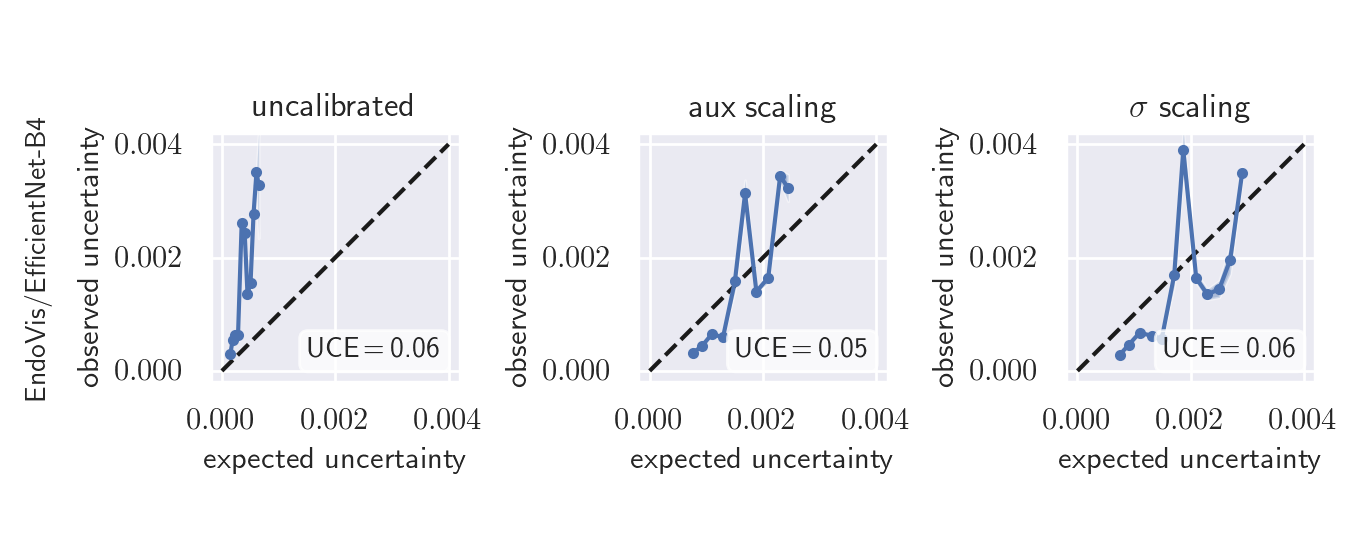

In [78]:
if base_model == 'efficientnetb4':
    fig, ax = plt.subplots(1, 3, figsize=(6.8, 2.75))

    alpha = 0.4
    props = dict(boxstyle='round', facecolor='white', alpha=0.75)

    err_uncal = torch.stack(err_uncal_list).mean(dim=0).cpu()
    err_uncal_var = torch.stack(err_uncal_list).std(dim=0).cpu()
    uncert_uncal = torch.stack(uncert_uncal_list).mean(dim=0).cpu()
    ax[0].plot([0, 0.004], [0, 0.004], 'k--')
    ax[0].plot(uncert_uncal, err_uncal, marker='.', label='uncal')
    ax[0].fill_between(uncert_uncal, err_uncal-err_uncal_var, err_uncal+err_uncal_var, alpha=alpha)
    ax[0].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[0].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[0].set_xlim([-0.0002, 0.0042])
    ax[0].set_ylim([-0.0002, 0.0042])
    ax[0].set_xticks([0, 0.002, 0.004])
    ax[0].set_yticks([0, 0.002, 0.004])
    ax[0].set_aspect(1)
    ax[0].set_title(r'uncalibrated')
    textstr0 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_uncal_list)*100).mean().item())
    ax[0].text(0.925, 0.075, textstr0, transform=ax[0].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_aux = torch.stack(err_aux_list).mean(dim=0).cpu()
    err_aux_var = torch.stack(err_aux_list).std(dim=0).cpu()
    uncert_aux = torch.stack(uncert_aux_list).mean(dim=0).cpu()
    ax[1].plot([0, 0.004], [0, 0.004], 'k--')
    ax[1].plot(uncert_aux, err_aux, marker='.', label='uncal')
    ax[1].fill_between(uncert_aux, err_aux-err_aux_var, err_aux+err_aux_var, alpha=alpha)
    ax[1].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[1].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[1].set_xlim([-0.0002, 0.0042])
    ax[1].set_ylim([-0.0002, 0.0042])
    ax[1].set_xticks([0, 0.002, 0.004])
    ax[1].set_yticks([0, 0.002, 0.004])
    ax[1].set_aspect(1)
    ax[1].set_title(r'aux scaling')
    textstr1 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_aux_list)*100).mean().item())
    ax[1].text(0.925, 0.075, textstr1, transform=ax[1].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_s = torch.stack(err_s_list).mean(dim=0).cpu()
    err_s_var = torch.stack(err_s_list).std(dim=0).cpu()
    uncert_s = torch.stack(uncert_s_list).mean(dim=0).cpu()
    ax[2].plot([0, 0.004], [0, 0.004], 'k--')
    ax[2].plot(uncert_s, err_s, marker='.', label='uncal')
    ax[2].fill_between(uncert_s, err_s-err_s_var, err_s+err_s_var, alpha=alpha)
    ax[2].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[2].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[2].set_xlim([-0.0002, 0.0042])
    ax[2].set_ylim([-0.0002, 0.0042])
    ax[2].set_xticks([0, 0.002, 0.004])
    ax[2].set_yticks([0, 0.002, 0.004])
    ax[2].set_aspect(1)
    ax[2].set_title(r'$ \sigma $ scaling')
    textstr2 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_s_list)*100).mean().item())
    ax[2].text(0.925, 0.075, textstr2, transform=ax[2].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    ax[0].annotate(r'EndoVis/EfficientNet-B4', xy=(0, 0.5), xytext=(-ax[0].yaxis.labelpad - 5, 0),
                   xycoords=ax[0].yaxis.label, textcoords='offset points',
                   size='large', ha='right', va='center', fontsize=10, rotation=90)
    fig.tight_layout()
    fig.show()

    fig.savefig(f"results_levi_endovis_{base_model}.pdf", bbox_inches='tight', pad_inches=0.01)
    save_log(base_model)

In [79]:
np.save(f"uce_uncal_levi_endovis_{base_model}", np.array([i.detach().numpy() for i in uce_uncal_list]))
np.save(f"err_uncal_levi_endovis_{base_model}", np.array([i.detach().numpy() for i in err_uncal_list]))
np.save(f"uncert_uncal_levi_endovis_{base_model}", np.array([i.detach().numpy() for i in uncert_uncal_list]))

np.save(f"uce_s_levi_endovis_{base_model}", np.array([i.detach().numpy() for i in uce_s_list]))
np.save(f"err_s_levi_endovis_{base_model}", np.array([i.detach().numpy() for i in err_s_list]))
np.save(f"uncert_s_levi_endovis_{base_model}", np.array([i.detach().numpy() for i in uncert_s_list]))

np.save(f"uce_aux_levi_endovis_{base_model}", np.array([i.detach().numpy() for i in uce_aux_list]))
np.save(f"err_aux_levi_endovis_{base_model}", np.array([i.detach().numpy() for i in err_aux_list]))
np.save(f"uncert_aux_levi_endovis_{base_model}", np.array([i.detach().numpy() for i in uncert_aux_list]))